# FTUs⚕️Segm: EDA🔎 & baseline Lightning⚡Flash on tiled images

This is derived from Flash docs and paralele competition: https://www.kaggle.com/code/jirkaborovec/tract-segm-eda-flash-deeplab-albumentation

In [1]:
!pip uninstall -y torchtext
# !pip install -q --upgrade torch torchvision
!mkdir -p frozen_packages
!cp ../input/starter-flash-semantic-segmentation/frozen_packages/* frozen_packages/
!cp ../input/ftus-segm-eda-viewer/frozen_packages/* frozen_packages/
!pip install -q "lightning-flash[image]" "torchmetrics<0.8" --no-index --find-links frozen_packages/
!pip install -q -U timm segmentation-models-pytorch --no-index --find-links frozen_packages/
!pip install -q 'kaggle-image-segmentation' --no-index --find-links frozen_packages/

! pip list | grep -e torch -e lightning
! nvidia-smi -L

Found existing installation: torchtext 0.12.0
Uninstalling torchtext-0.12.0:
  Successfully uninstalled torchtext-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
dask-cudf 21.10.1 requires dask==2021.09.1, but you have dask 2022.2.0 which is incompatible.
dask-cudf 21.10.1 requires distributed==2021.09.1, but you have distributed 2022.2.0 which is incompatible.
efficientnet-pytorch                  0.6.3
lightning-bolts                       0.5.0
lightning-flash                       0.7.5
pytorch-ignite                        0.4.9
pytorch-lightning                     1.6.4
segmentation-models-pytorch           0.2.1
torch                                 1.11.0
torchaudio                            0

## Loading dataset

In this case we are using generated segmentation mask exported in this dataset: https://www.kaggle.com/datasets/jirkaborovec/hacking-the-human-body-annotation-masks

and generated from following EDA kernel: https://www.kaggle.com/code/jirkaborovec/ftus-segm-eda-export-rle-mask

In [2]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt

DATASET_FOLDER = "/kaggle/input/hubmap-organ-segmentation"
ANNOT_DATASET = "/kaggle/input/hacking-the-human-body-annotation-masks"
path_csv = os.path.join(DATASET_FOLDER, "train.csv")
df_train = pd.read_csv(path_csv)
display(df_train.head())

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female


In [3]:
df_test = pd.read_csv(os.path.join(DATASET_FOLDER, "test.csv"))

display(df_test.head())

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness
0,10078,spleen,Hubmap,2023,2023,0.4945,4


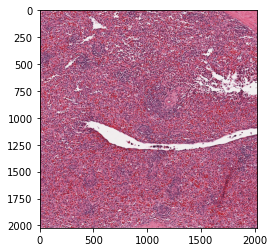

In [4]:
ls = glob.glob(os.path.join(DATASET_FOLDER, 'test_images', '*'))
WITH_SUBMISSION = len(ls) > 1

for fname in ls[:2]:
    plt.imshow(plt.imread(fname))

# Make a grid/tiles

In [5]:
!mkdir -p /kaggle/temp/images
!mkdir -p /kaggle/temp/masks

In [6]:
import numpy as np
from PIL import Image

def tile_image(p_img, folder, size: int = 1024) -> list:
    w = h = size
    im = np.array(Image.open(p_img))
    # https://stackoverflow.com/a/47581978/4521646
    tiles = [im[i:(i + h), j:(j + w), ...] for i in range(0, im.shape[0], h) for j in range(0, im.shape[1], w)]
    idxs = [(i, (i + h), j, (j + w)) for i in range(0, im.shape[0], h) for j in range(0, im.shape[1], w)]
    name, _ = os.path.splitext(os.path.basename(p_img))
    files = []
    for k, tile in enumerate(tiles):
        if tile.shape[:2] != (h, w):
            tile_ = tile
            tile = np.zeros_like(tiles[0])
            tile[:tile_.shape[0], :tile_.shape[1], ...] = tile_
        p_img = os.path.join(folder, f"{name}_{k:02}.png")
        Image.fromarray(tile).save(p_img)
        files.append(p_img)
    return files, idxs


tiles_img, _ = tile_image("../input/hubmap-organ-segmentation/train_images/12233.tiff", "/kaggle/temp/images", size=1024)
tiles_seg, idxs = tile_image("../input/hacking-the-human-body-annotation-masks/train_masks/12233.png", "/kaggle/temp/masks", size=1024)

!ls -lh /kaggle/temp/images
!ls -lh /kaggle/temp/masks

total 15M
-rw-r--r-- 1 root root 1.6M Jul  2 10:43 12233_00.png
-rw-r--r-- 1 root root 2.0M Jul  2 10:43 12233_01.png
-rw-r--r-- 1 root root 1.5M Jul  2 10:43 12233_02.png
-rw-r--r-- 1 root root 1.9M Jul  2 10:43 12233_03.png
-rw-r--r-- 1 root root 2.2M Jul  2 10:44 12233_04.png
-rw-r--r-- 1 root root 1.7M Jul  2 10:44 12233_05.png
-rw-r--r-- 1 root root 1.5M Jul  2 10:44 12233_06.png
-rw-r--r-- 1 root root 1.8M Jul  2 10:44 12233_07.png
-rw-r--r-- 1 root root 1.2M Jul  2 10:44 12233_08.png
total 40K
-rw-r--r-- 1 root root 1.1K Jul  2 10:44 12233_00.png
-rw-r--r-- 1 root root 1.1K Jul  2 10:44 12233_01.png
-rw-r--r-- 1 root root 1.1K Jul  2 10:44 12233_02.png
-rw-r--r-- 1 root root 4.0K Jul  2 10:44 12233_03.png
-rw-r--r-- 1 root root 1.1K Jul  2 10:44 12233_04.png
-rw-r--r-- 1 root root 1.1K Jul  2 10:44 12233_05.png
-rw-r--r-- 1 root root 2.1K Jul  2 10:44 12233_06.png
-rw-r--r-- 1 root root 5.0K Jul  2 10:44 12233_07.png
-rw-r--r-- 1 root root 1.8K Jul  2 10:44 12233_08.png


## Show the image tiles with segmentations

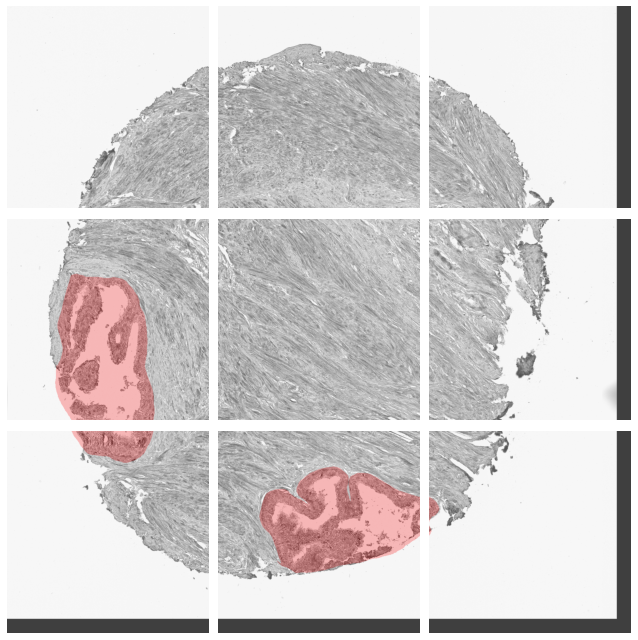

In [7]:
import matplotlib.pyplot as plt
from skimage import color

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))
for i, (p_img, p_seg) in enumerate(zip(tiles_img, tiles_seg)):
    img = plt.imread(p_img)
    mask = np.array(Image.open(p_seg))
    axes[i // 3, i % 3].imshow(color.label2rgb(mask, img, bg_label=0, bg_color=(1.,1.,1.), alpha=0.25))
    axes[i // 3, i % 3].set_axis_off()
fig.tight_layout()

### Back recosntruction

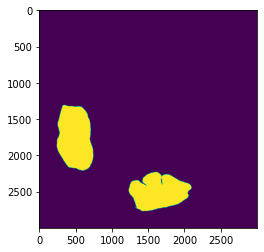

In [8]:
tiles = [np.array(Image.open(p_seg)) for p_seg in tiles_seg]
im = plt.imread("../input/hubmap-organ-segmentation/train_images/12233.tiff")
seg = np.zeros(im.shape[:2], dtype=np.uint8)
for tile, (i1, i2, j1, j2) in zip(tiles, idxs):
    i2 = min(i2, im.shape[0])
    j2 = min(j2, im.shape[1])
    seg[i1:i2, j1:j2] = tile[:(i2 - i1), :(j2 - j1)]
plt.imshow(seg)

## Process dataset

In [9]:
from tqdm.auto import tqdm
from joblib import Parallel, delayed

TILE_SIZE = 1024

for dir_source, dir_target in [
    (os.path.join(DATASET_FOLDER, 'train_images'), "/kaggle/temp/images"),
    (os.path.join(ANNOT_DATASET, 'train_masks'), "/kaggle/temp/masks"),
]:
    ls = glob.glob(os.path.join(dir_source, '*'))
    _= Parallel(n_jobs=3)(
        delayed(tile_image)(p_img, dir_target, size=TILE_SIZE) for p_img in tqdm(ls)
    )

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

# Lightning⚡Flash & Unet++

lets follow the Semantinc segmentation example: https://lightning-flash.readthedocs.io/en/stable/reference/semantic_segmentation.html

In [10]:
import torch

import flash
import numpy as np
from flash.core.data.utils import download_data
from flash.image import SemanticSegmentation, SemanticSegmentationData

/opt/conda/lib/python3.7/site-packages/pretrainedmodels/datasets/utils.py:33: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  def __init__(self, size, interpolation=Image.BILINEAR):
/opt/conda/lib/python3.7/site-packages/pystiche/image/io.py:52: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  "nearest": Image.NEAREST,
/opt/conda/lib/python3.7/site-packages/pystiche/image/io.py:53: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  "bilinear": Image.BILINEAR,
/opt/conda/lib/python3.7/site-packages/pystiche/image/io.py:54: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  "bicubic": Image.BICUBIC,


## 1. Create the DataModule

In [11]:
IMAGE_SIZE = (384, 384)

datamodule = SemanticSegmentationData.from_folders(
    train_folder="/kaggle/temp/images",
    train_target_folder="/kaggle/temp/masks",
    val_split=0.01 if WITH_SUBMISSION else 0.2,
    predict_folder=os.path.join(DATASET_FOLDER, 'test_images'),
    transform_kwargs=dict(image_size=IMAGE_SIZE),
    num_classes=2,
    batch_size=12,
    num_workers=2,
)

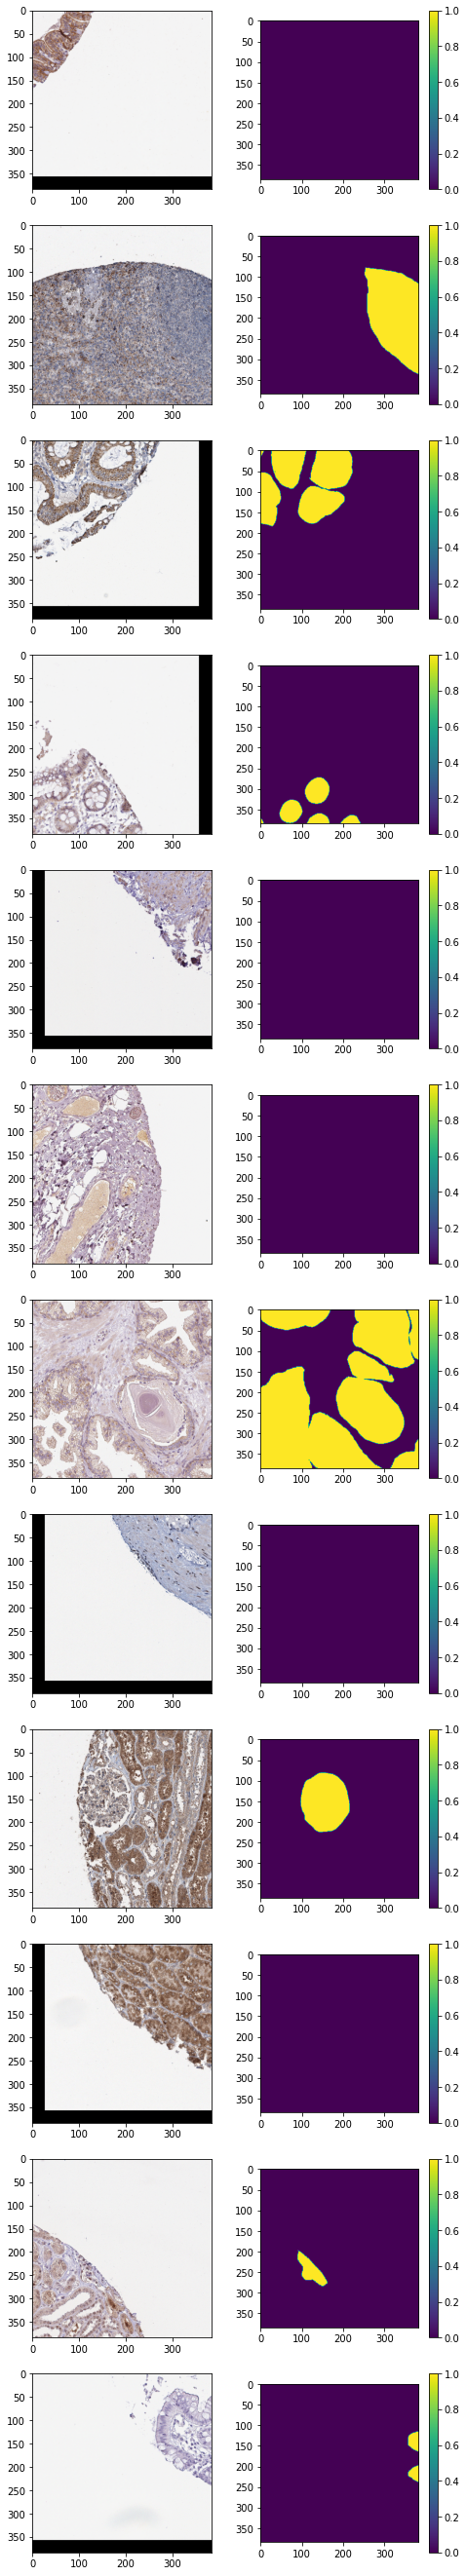

In [12]:
fig, axarr = plt.subplots(ncols=2, nrows=datamodule.batch_size, figsize=(8, 4 * datamodule.batch_size))

for batch in datamodule.train_dataloader():
    for i in range(len(batch['input'])):
        segm = batch['target'][i].numpy()
        img = np.rollaxis(batch['input'][i].cpu().numpy(), 0, 3)
        axarr[i, 0].imshow(img)
        seg = axarr[i, 1].imshow(segm, vmin=0, vmax=1)
        plt.colorbar(seg, ax=axarr[i, 1])
    break

## 2. Build the task

In [13]:
from pprint import pprint

pprint(SemanticSegmentation.available_heads())
pprint(SemanticSegmentation.available_backbones()['unetplusplus'])

['deeplabv3',
 'deeplabv3plus',
 'fpn',
 'linknet',
 'manet',
 'pan',
 'pspnet',
 'unet',
 'unetplusplus']
['densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'dpn107',
 'dpn131',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'efficientnet-b0',
 'efficientnet-b0',
 'efficientnet-b1',
 'efficientnet-b1',
 'efficientnet-b2',
 'efficientnet-b2',
 'efficientnet-b3',
 'efficientnet-b3',
 'efficientnet-b4',
 'efficientnet-b4',
 'efficientnet-b5',
 'efficientnet-b5',
 'efficientnet-b6',
 'efficientnet-b6',
 'efficientnet-b7',
 'efficientnet-b7',
 'efficientnet-b8',
 'efficientnet-l2',
 'gernet_l',
 'gernet_m',
 'gernet_s',
 'inceptionresnetv2',
 'inceptionv4',
 'mobilenet_v2',
 'mobilenetv3_large_075',
 'mobilenetv3_large_100',
 'mobilenetv3_large_minimal_100',
 'mobilenetv3_small_075',
 'mobilenetv3_small_100',
 'mobilenetv3_small_minimal_100',
 'regnetx_002',
 'regnetx_004',
 'regnetx_006',
 'regnetx_008',
 'regnetx_016',
 'regnetx_032',
 'regnetx_040',
 'regnetx_064',
 'regnetx_08

In [14]:
import segmentation_models_pytorch as smp

model = SemanticSegmentation(
    backbone="efficientnet-b4",
    head="unetplusplus",
    pretrained=False,
    optimizer="Adamax",
    learning_rate=0.05,
    lr_scheduler=("StepLR", {"step_size": 1500}),
    # loss_fn=smp.losses.DiceLoss(mode='binary'),
    num_classes=datamodule.num_classes,
)

/opt/conda/lib/python3.7/site-packages/torch/distributed/_sharded_tensor/__init__.py:10: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  DeprecationWarning
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metrics'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


## 3. Create the trainer and finetune the model

In [15]:
import pytorch_lightning as pl

trainer = flash.Trainer(
    max_epochs=20 if WITH_SUBMISSION else 10,
    logger=pl.loggers.CSVLogger(save_dir='logs/'),
    gpus=torch.cuda.device_count(),
    precision=16 if torch.cuda.is_available() else 32,
    accumulate_grad_batches=8,
    gradient_clip_val=0.01,
    limit_train_batches=1.0 if WITH_SUBMISSION else 0.5,
    limit_val_batches=1.0 if WITH_SUBMISSION else 0.5,
)

In [16]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Train the model
trainer.finetune(model, datamodule=datamodule, strategy="no_freeze")

# Save the model!
trainer.save_checkpoint("semantic_segmentation_model.pt")

/opt/conda/lib/python3.7/site-packages/flash/core/trainer.py:213: UserWarning: The model contains a default finetune callback.
  warnings.warn("The model contains a default finetune callback.", UserWarning)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Show training progress

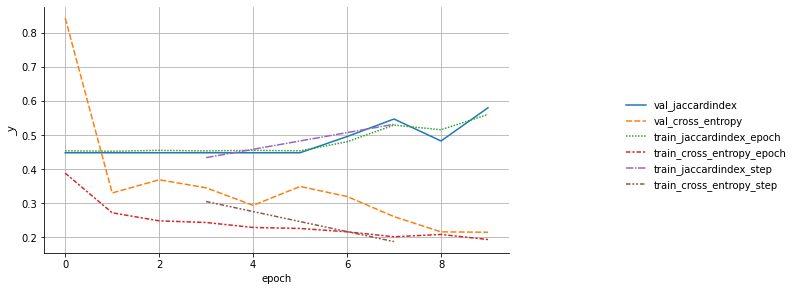

In [17]:
import seaborn as sn

metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
del metrics["step"]
metrics.set_index("epoch", inplace=True)
# display(metrics.dropna(axis=1, how="all").head())
g = sn.relplot(data=metrics, kind="line")
plt.gcf().set_size_inches(12, 4)
plt.grid()

## 4. Segment a few images!

In [18]:
sample_imgs = tiles_img[:5]

dm = SemanticSegmentationData.from_files(
    predict_files=sample_imgs,
    transform_kwargs=dict(image_size=IMAGE_SIZE),
    batch_size=3,
)

Predicting: 105it [00:00, ?it/s]

float32 0.06614584 0.9607843
float32 0.124402575 0.9607843
float32 0.0 0.9607843
float32 0.09765625 0.9607843
float32 0.101424634 0.9607843


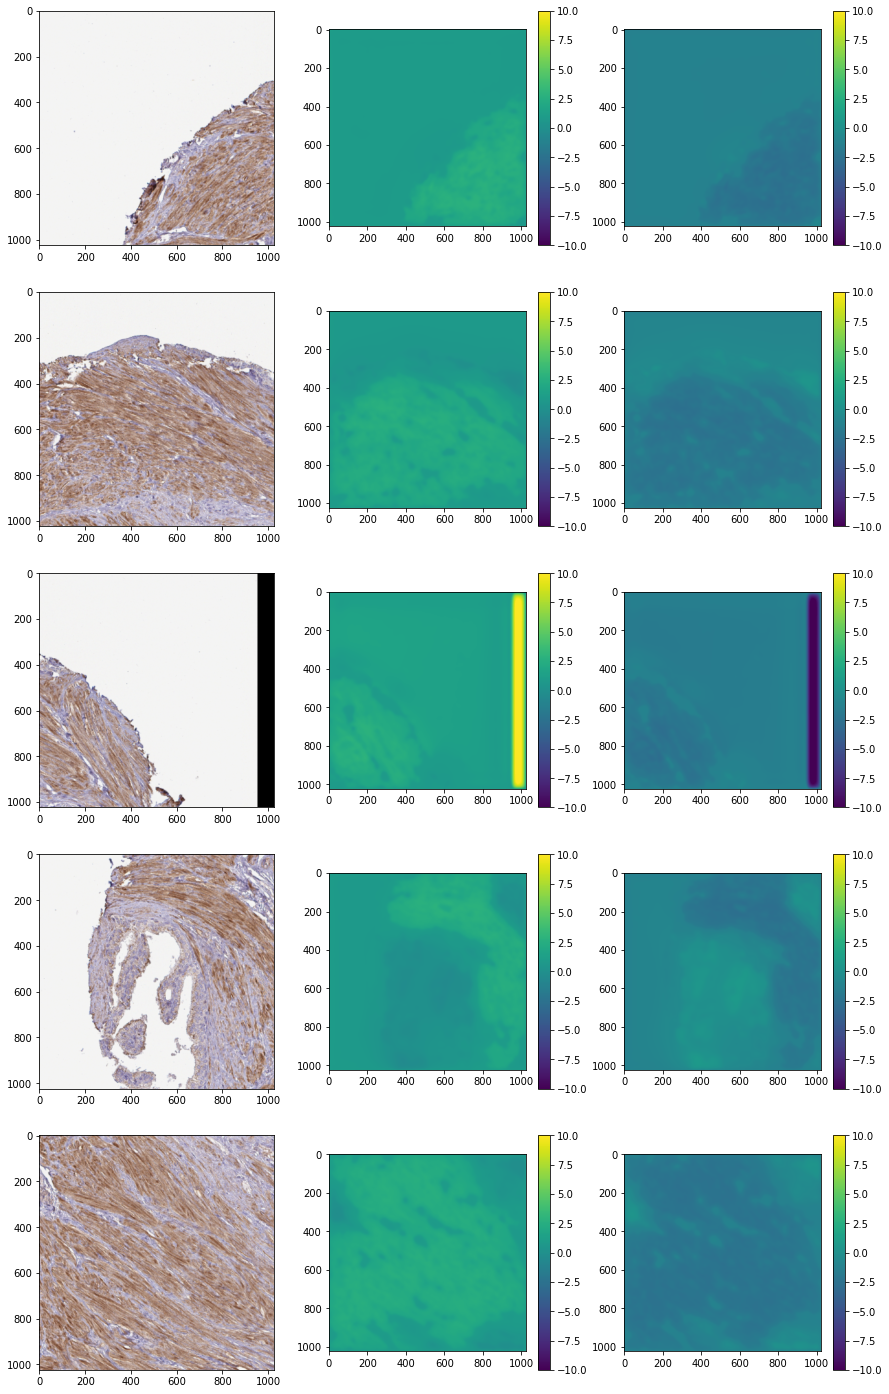

In [19]:
from itertools import chain

nrows = max(2, len(sample_imgs))
fig, axarr = plt.subplots(ncols=3, nrows=nrows, figsize=(15, 5 * nrows))

preds = trainer.predict(model, datamodule=dm)
preds = list(chain(*preds))
for i, pred in enumerate(preds):
    # print(pred.keys())
    img = np.rollaxis(pred['input'].cpu().numpy(), 0, 3)
    print(img.dtype, img.min(), img.max())
    axarr[i, 0].imshow(img)
    for j, seg in enumerate(pred['preds'].cpu().numpy()):
        p = axarr[i, j + 1].imshow(seg, vmin=-10, vmax=10)
        plt.colorbar(p, ax=axarr[i, j + 1])

# Inference 🔥

In [20]:
model = SemanticSegmentation.load_from_checkpoint(
    "semantic_segmentation_model.pt"
)
test_images = glob.glob(os.path.join(DATASET_FOLDER, "test_images", "*.tiff"))
print(f"images: {len(test_images)}")

!rm /kaggle/temp/images/*
!rm /kaggle/temp/masks/*

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metrics'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


images: 1


In [21]:
import cv2
import numpy as np
from itertools import chain
from kaggle_imsegm.mask import rle_encode
from torch.utils.data import DataLoader
# from skimage.transform import rescale, resize

df_test['pixel_size'] =  df_test['pixel_size'].fillna(0.4)

preds = []
for _, row in df_test.iterrows():
    scale = row["pixel_size"] / 0.4
    test_img = os.path.join(DATASET_FOLDER, "test_images", f"{row['id']}.tiff")
    im = plt.imread(test_img)
    
    # perform scaling on level tiles as the input is scaled to the CNN input size anyway
    tiles_img, idxs = tile_image(test_img, "/kaggle/temp/images", size=int(TILE_SIZE / scale))
    dm = SemanticSegmentationData.from_files(
        predict_files=tiles_img,
        # predict_transform=SemanticSegmentationInputTransform,
        transform_kwargs=dict(image_size=IMAGE_SIZE),
        num_classes=2,
        batch_size=3,
        num_workers=2,
    )
    pred = trainer.predict(model, datamodule=dm, output="labels")
    pred = list(chain(*pred))
    
    seg = np.zeros(im.shape[:2], dtype=np.uint8)
    for tile, (i1, i2, j1, j2) in zip(pred, idxs):
        i2 = min(i2, im.shape[0])
        j2 = min(j2, im.shape[1])
        seg[i1:i2, j1:j2] = np.array(tile, dtype=np.uint8)[:(i2 - i1), :(j2 - j1)]
    # seg = resize(seg * 255, img.shape[:2], order=0) / 255
    
    rle = rle_encode(seg.T) if np.sum(seg) > 1 else {}
    name, _ = os.path.splitext(os.path.basename(test_img))
    preds.append({"id": row['id'], "rle": rle.get(1, "")})

df_pred = pd.DataFrame(preds)
display(df_pred[df_pred["rle"] != ""].head())

Predicting: 105it [00:00, ?it/s]

,id,rle
0,10078,26742 7 28762 17 30784 23 32805 30 34828 33 36...


## Finalize submissions

In [22]:
df_ssub = pd.read_csv(os.path.join(DATASET_FOLDER, "sample_submission.csv"))
del df_ssub['rle']
df_pred = df_ssub.merge(df_pred, on='id')

df_pred[['id', 'rle']].to_csv("submission.csv", index=False)

!head submission.csv

id,rle
10078,26742 7 28762 17 30784 23 32805 30 34828 33 36850 38 38873 43 40896 46 42919 46 44942 46 46965 46 48988 45 51012 44 53035 43 55058 42 57081 41 59104 40 61127 38 63150 37 65172 37 67194 36 69216 36 71237 37 73258 38 75277 41 77295 45 79315 47 81336 49 83358 49 85379 51 87401 52 89423 53 91446 53 93468 54 95490 55 97512 57 99535 57 101557 59 103580 60 103650 4 105602 62 105670 8 107625 77 109648 78 111670 79 113693 79 115716 79 117739 80 119762 80 121785 80 123808 80 125831 80 127854 80 129878 79 131901 79 133925 78 135949 77 137972 76 139996 75 142020 73 144044 72 146068 70 148092 68 150115 43 150165 17 152139 40 152191 12 154163 38 154217 7 156187 36 158211 33 160235 31 162259 29 164283 27 166306 26 168330 25 170354 23 172378 21 174402 19 176426 17 178450 14 180474 11 182500 5 511818 1 513840 2 515863 2 517886 2 519908 3 521931 3 523954 3 525976 4 527999 4 530021 5 532044 5 534067 5 536089 6 538112 6 540135 6 542158 6 544181 6 546204 6 548227 6 550250 6 552273 6 554296 6 5